In [52]:
import torch 
from models import NONA_FT
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from ft_eval import RSNADataset, get_fold_indices, load_data_params, collate
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torcheval.metrics.functional import mean_squared_error
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

In [62]:
device = torch.device('cpu')
res = resnet18(weights='DEFAULT')

model_type = 'nona euclidean'
pred_sim = model_type.split(" ")
if len(pred_sim)==2:
    predictor_head = pred_sim[0]
    sim = pred_sim[1]
else:
    predictor_head= model_type 
    sim = None

model=NONA_FT(feature_extractor=res, 
                        hl_sizes=[200,50], 
                        predictor=predictor_head, 
                        similarity=sim, 
                        task='regression', 
                        dtype=torch.float32)


In [63]:
rsna_sft_weights = torch.load(f'results/rsna/models/02212246/{model_type}_1.pth', map_location=device)
model.load_state_dict(rsna_sft_weights)

<All keys matched successfully>

In [55]:
task, data_df, transform, fe, data_percentage = load_data_params('rsna')
idx_dict = get_fold_indices(data_df=data_df, seed=1, data_percentage=data_percentage)

In [56]:
def collate(batch):
    x, y = zip(*batch)
    x = torch.stack(x).to(device).to(torch.float32)
    y = torch.tensor(y, dtype=torch.float32, device=device)
    return x, y

train_dataset = RSNADataset(idx_dict['train'], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True, collate_fn=collate)

test_dataset = RSNADataset(idx_dict['test'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, collate_fn=collate)

In [57]:
with torch.no_grad():
    for (X_train, y_train), (X_test, y_test) in zip(train_loader, test_loader): # one batch
        y_hat_train, train_embeddings = model(X_train, X_train, y_train, get_embeddings=True)
        y_hat_test, test_embeddings = model(X_test, X_train, y_train, get_embeddings=True)

In [58]:
mse = torch.mean((y_test - y_hat_test)**2)
mse

tensor(0.0221)

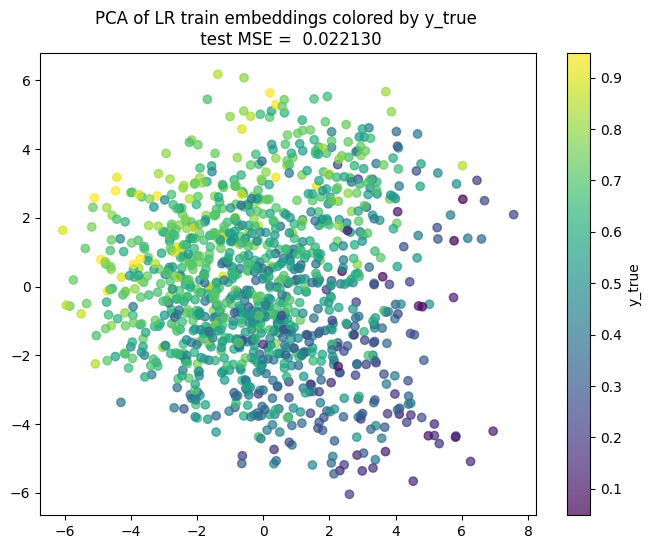

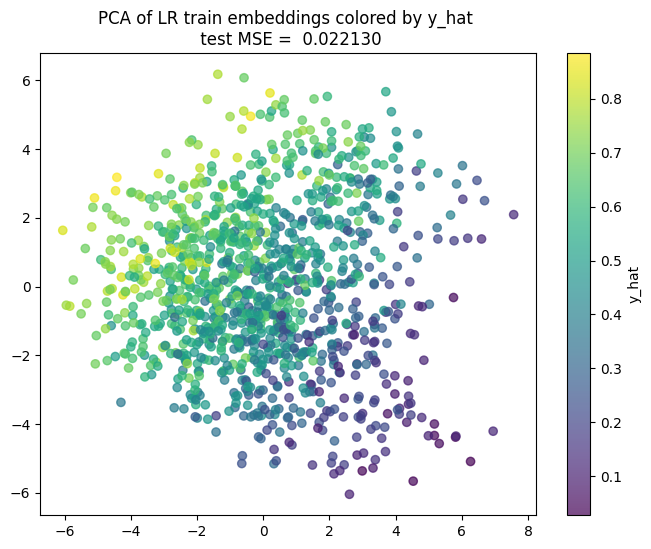

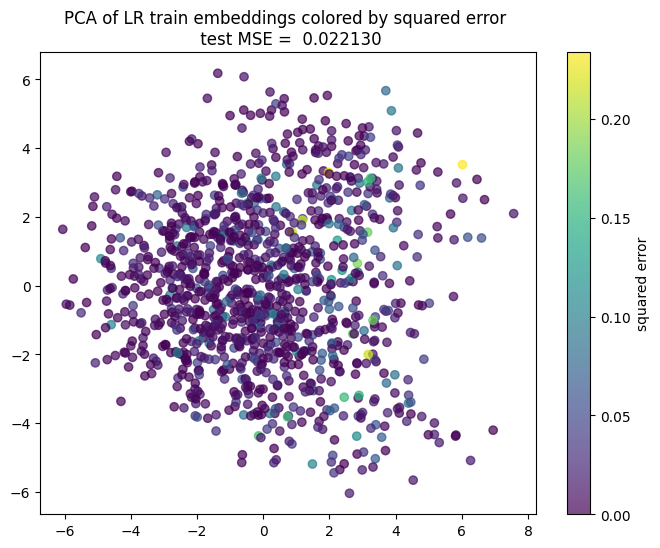

In [61]:
proj_dim = 2

embedding_set = 'train'
if embedding_set == 'train':
    embeddings = train_embeddings
    label_dict = {'y_true': y_train, 'y_hat': y_hat_train, 'squared error': (y_hat_train - y_train)**2}    
elif embedding_set == 'test':
    embeddings = test_embeddings
    label_dict = {'y_true': y_test, 'y_hat': y_hat_test, 'squared error': (y_hat_test - y_test)**2}

proj_type = 'pca'
if proj_type == 'tsne':
    proj = TSNE(n_components=proj_dim, random_state=42)
elif proj_type == 'pca':
    proj = PCA(n_components=proj_dim, random_state=42)

reduced_embeddings = proj.fit_transform(embeddings)

model_type = 'LR'

for label_to_vis, y in label_dict.items():
    
    title = f"{proj_type.upper()} of {model_type} {embedding_set} embeddings colored by {label_to_vis} \n test MSE = {mse.item() : 4f}"
    
    fig = plt.figure(figsize=(8, 6))#, dpi=200)
    if proj_dim == 2:
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y, cmap='viridis', alpha=0.7)
        plt.colorbar(label=label_to_vis)
        plt.title(title)

    elif proj_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=y, cmap='viridis', alpha=0.7)
        fig.colorbar(ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=y, cmap='viridis', alpha=0.7), label=label_to_vis)
        ax.set_title(title)
    plt.show()